In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
import glob
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

2022-11-21 18:48:43.371838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:48:43.817392: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 18:48:45.177030: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/apps/cuda/11.3/lib64
2022-11-21 18:48:45.177189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

---

## Load Data

In [52]:
data = np.load('data.npz')
x = data['x'] / 255
y = data['y']
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)
print(x.shape)
print(y.shape)

(46640, 150, 150)
(46640, 14549)


## Modeling (Simple CNN)

In [4]:
input_shape = (150, 150, 1)

In [5]:
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

2022-11-21 12:40:23.230676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 12:40:28.560312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2022-11-21 12:40:28.567410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10405 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-11-21 12:40:28.570059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/t

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

## Data Argumentation

In [7]:
x = x.reshape(46640,150,150,1)

In [17]:
data_generator = ImageDataGenerator(
    rotation_range=180,
    brightness_range=(0.9, 1.1)
)
data_generator.fit(x)

NameError: name 'ImageDataGenerator' is not defined

## Model Training

In [9]:
cnn.fit_generator(data_generator.flow(x, y, batch_size=32), steps_per_epoch=len(x) / 32, 
                  validation_data=(x, y), epochs=1000)

/tmp/ipykernel_56456/3168405275.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(data_generator.flow(x_ag, y, batch_size=32), steps_per_epoch=len(x_ag) / 32,


Epoch 1/1000


2022-11-21 12:41:29.103580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1457/1457 [==============================] - 225s 150ms/step - loss: 6.7078 - accuracy: 0.2585 - val_loss: 6.3204 - val_accuracy: 0.2767
Epoch 2/1000
1457/1457 [==============================] - 191s 131ms/step - loss: 6.0591 - accuracy: 0.2848 - val_loss: 5.8540 - val_accuracy: 0.2919
Epoch 3/1000
1457/1457 [==============================] - 187s 128ms/step - loss: 5.7184 - accuracy: 0.2963 - val_loss: 5.5361 - val_accuracy: 0.3019
Epoch 4/1000
1457/1457 [==============================] - 187s 128ms/step - loss: 5.4175 - accuracy: 0.3062 - val_loss: 5.2401 - val_accuracy: 0.3114
Epoch 5/1000
1457/1457 [==============================] - 188s 129ms/step - loss: 5.1375 - accuracy: 0.3157 - val_loss: 4.9807 - val_accuracy: 0.3223
Epoch 6/1000
1457/1457 [==============================] - 186s 128ms/step - loss: 4.8705 - accuracy: 0.3260 - val_loss: 4.7148 - val_accuracy: 0.3325
Epoch 7/1000
1457/1457 [==============================] - 188s 129ms/step - loss: 4.6182 - accuracy: 0.3341 - val

KeyboardInterrupt: 

In [30]:
score = cnn.evaluate(x, y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2022-11-21 18:58:21.714475: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4197600000 exceeds 10% of free system memory.
2022-11-21 18:58:38.636569: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4197600000 exceeds 10% of free system memory.


Test loss: 0.8986639976501465
Test accuracy: 0.7835119962692261


In [10]:
cnn.save('Imprint_ep106_simplecnn_argu_rotation_brightness')

INFO:tensorflow:Assets written to: Imprint_ep106_simplecnn_argu_rotation_brightness/assets


INFO:tensorflow:Assets written to: Imprint_ep106_simplecnn_argu_rotation_brightness/assets


---

## 모델 추론

In [4]:
model = tf.keras.models.load_model('Imprint_ep106_simplecnn_argu_rotation_brightness')

2022-11-21 18:49:00.502245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:49:05.930521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2022-11-21 18:49:05.937920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10405 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-11-21 18:49:05.945715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/t

In [16]:
y_pred = model.predict(x)

1458/1458 [==============================] - 10s 7ms/step


In [18]:
y_pred.shape

(46640, 14549)

In [29]:
np.argmax(y[:20], axis=1).reshape(-1,1)

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [ 1],
       [14],
       [15],
       [16],
       [17],
       [18]])

In [30]:
np.argmax(y_pred[:20], axis=1).reshape(-1,1)

array([[   0],
       [3495],
       [6970],
       [3404],
       [   4],
       [   5],
       [   6],
       [   7],
       [  17],
       [ 315],
       [  10],
       [3587],
       [  12],
       [   4],
       [   1],
       [ 279],
       [  15],
       [  16],
       [  17],
       [  18]])

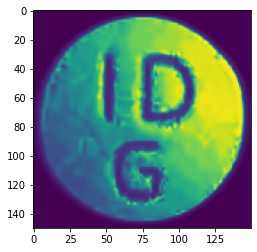

In [36]:
img1 = cv.imread('../../Data/separate/front/front_00001.png', cv.IMREAD_GRAYSCALE)
img1 = cv.equalizeHist(img1)
img1 = cv.fastNlMeansDenoising(img1, None, 10, 7, 21)
plt.imshow(img1)

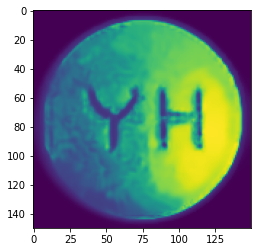

In [37]:
img2 = cv.imread('../../Data/separate/front/front_00002.png', cv.IMREAD_GRAYSCALE)
img2 = cv.equalizeHist(img2)
img2 = cv.fastNlMeansDenoising(img2, None, 10, 7, 21)
plt.imshow(img2)

In [38]:
inputs = np.stack((img1, img2), axis=0)
inputs.shape

(2, 150, 150)

In [53]:
x = x/255.0

In [ ]:

inputs = inputs/255.0

In [47]:
x[:10,:].shape

(10, 150, 150)

In [41]:
y_pred = model.predict(inputs)

1/1 [==============================] - 0s 70ms/step


In [54]:
y_p = model.predict(x[:10,:])

1/1 [==============================] - 0s 74ms/step


In [43]:
np.argmax(y_pred, axis=1).reshape(-1,1)

array([[   0],
       [3495]])

In [55]:
np.argmax(y_p, axis=1).reshape(-1,1)

array([[   0],
       [3495],
       [6970],
       [3404],
       [   4],
       [   5],
       [   6],
       [   7],
       [  17],
       [ 315]])

In [28]:
np.argmax(y, axis=1).reshape(-1,1)[:10]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [ ]:
def predict_pill_by_print(y_pred):
    

In [7]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("asdl.csv", encoding='utf-8')[['ITEM_SEQ', 'ITEM_NAME']]
df

/tmp/ipykernel_153511/3011114623.py:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("asdl.csv", encoding='utf-8')[['ITEM_SEQ', 'ITEM_NAME']]


,ITEM_SEQ,ITEM_NAME
0,200808876,가스디알정50밀리그램(디메크로틴산마그네슘)
1,200808877,페라트라정2.5밀리그램(레트로졸)
2,200809076,가스프렌정(모사프리드시트르산염이수화물)
3,200809276,디텐션정80밀리그램(발사르탄)
4,200809361,바르탄정(발사르탄)
...,...,...
23315,202104524,에소리움플러스정20/800밀리그램
23316,202104996,글루파엑스알서방정850밀리그램(메트포르민염산염)
23317,201601206,크레아진플러스정10/20mg
23318,202102255,빌다글립엠정50밀리그램(빌다글립틴)
